## Using control theory to manage climate change

by Ronald L. Rivest (with Alan Edelman, Henri Drake, and John M. Deutch)

January 24, 2020

This note describes and studies a very simple model of climate change and climate management, based loosely on John Deutch's paper [REF], and explores using a control-theory approach to managing climate change.  

The climate change manager first chooses a desired trajectory for climate temperature increase, and then the control policy works to keep the climate on such a trajectory, as a function of the "error signal" (how much the current temperature exceeds the desired temperature for that year).

The climate model allows for (gaussian, unbiased) "noise" in the evolution of CO2 concentration and in the evoluation of the equilibrium climate sensitivity.  (These are present in the model, but currently turned-off/unimplemented, as they would require policy optimization to run many simulations to evaluate expected policy cost.)  (There is nothing in the model that requires gaussian unbiased noise, although the code implements
only this kind of noise.)

The model incorporates a flexible way of specifying a climate management policy, in terms of how resources should be allocated among four climate management stragies (Reduction, Negative emissions, Adaptation, and Geoengineering), depending on the error signal.

The model also includes some "momentum" for each of the four strategies: the net level of effort for a strategy in a given year includes not only on the investment in that strategy for the given year, but also (with some decay) the net level of effort for that strategy in previous years.

The model includes consideration of "learning curves"---the effectiveness of a given incremental investment in a climate control strategy depends on the total cumulative
investment to date in that strategy.  This takes the form of a power law: each doubling of cumulative investment in a strategy increases the effectiveness of a marginal investment in that strategy by some fixed percentage (such as ten percent).  (To make this work, each strategy is given a fixed "initial investment".) (The interesting question here is whether the existence of learning curves favors policies that "put all of their bets on a single strategy" to maximize the learning benefits.) (Another 
interesting question is whether the assumption of such learning curves gives a much 
more optimistic picture of our likely future(s) than one without learning curves.)

Optimization is performed to find a policy of minimum cost, given a target temperature trajectory.  (The target temperature trajectory is not part of the policy;
it could be moved to become part of the policy, although this would 
significantly increase the computational cost of optimization.)

This model is weak on economic aspects: it includes a fixed gross world product (GWP) and includes a fixed discount rate to compare future dollars with current dollars.  (Right now the discount rate is set to 0.014.)

## LInks and Related work

John M. Deutch.
Joint Allocation of Climate Control Mechanisms
is the Cheapest Way to Reduce Global Climate Damage.
(preprint).

Mariia Belaia.
Optimal Climate Strategy with Mitigation, Carbon Removal, and Solar Geoengineering.
https://arxiv.org/abs/1903.02043

Sergei Soldatenko, Rafael Yusupov.
On the Application of Optimal Control Theory to Climate Engineering.
https://arxiv.org/abs/1709.05597

Naman Agarwal, Karan Singh and Elad Hazan.
New Methods in Control: The Gradient Perturbation Controller.
https://minimizingregret.wordpress.com/

# Julia Setup

In [82]:
# include routine to interpolate cubic monotone splines fitting given data
# used to create curve for target temperature increases.
include("interpolate_monotone.jl")

demo_bug (generic function with 1 method)

In [83]:
using Pkg
using Formatting
using Random
using PyPlot
using BlackBoxOptim

In [84]:
lg(x) = log(x) / log(2.0);    # lg is log base 2

# World State

### Climate state variables

The model incorporates three climate state variables in its world state:
* $c$ -- the concentration of CO2 in the atmosphere in ppm
* $\delta T$ -- the rise in temperature since pre-industrial in degrees Kelvin
* $ECS$ -- the equilibrium climate sensitivity (how much equilibrium $T$ would raise if $c$ were to double)

We assume these variables are continuous functions of time, but may use a discretized (annual) time for simulations.

The climate state variables  $c$ and $\delta T$  are assumed to be observable, while $ECS$ is not (for now).

In our initial experiments, we leave $ECS$ as a constant.

### Control state variables

The model incorporates four control variables affecting climate evolution; each has a "cumulative" and a "net" value:

* $R_{cum}, R_{net}$ -- emissions reduction
* $N_{cum}, N_{net}$ -- negative emissions
* $A_{cum}, A_{net}$ -- adaptation
* $G_{cum}, G_{net}$ -- geoengineering (solar reduction via aerosols)

All are measured in teradollars (T\$). 

The model studied here has two novel aspects:
* The cumulative investment aggregages the total investments
  made for a given strategy, but increments to the cumulative
  amount "increase in impact" as the cumulative investment
  increases, due to "***learning curve***" considerations.  
  
  For example,
  each doubling of cumulative investment may mean that the impact
  of an additional investment increases by (say) ten percent.
  An initial investment is required for each strategy in order to
  make this approach sensible; we choose a value of:
  $$ 
          II = 10 ~G\$ = 0.01 ~T\$\ .
  $$ 
* The net investment tracks the cumulative investment, in the
  sense that any increment to the cumulative investment is also
  added to the net investment.  However, the net investment also
  decays (depreciates) every year, say by ten percent.

The actual policy (control) variables are the incremental (one-year) change in the same four;
they are represented in lower case: $r, n, a, g$.  They are also measured in
teradollars.

Thus, $r(t)$ is the new investment in emissions reduction in year $t$.

Given the learning curve considerations, this has an effective
impact of
$$ 
    r_{eff}(t) = r(t) * (R_{cum}(t) / II)^{learning\_exponent} 
$$
which is aggregated into $R_{cum}$:
$$
    R_{cum}(1) = II \\
    R_{cum}(t+1) = R_{cum}(t) + r_{eff}(t) \ .
$$

In [85]:
II = 0.01    # initial investment (already made) in each strategy, in teradollars.

## If each doubling of investment yields a 10% marginal efficiency 
# improvement, then i-th dollar invested is like investing
# (assuming II investment initially)
# 1.10^lg((II+i)/II) = ((II+i)/II)^lg(1.10) = ((II+i)/II)^0.1375 dollars.
# where lg(x) is logarithm base two of x.

learning_constant = 1.00    # turn off for now
# 1.10 would mean ten percent more bang for the buck after a doubling of 
# cumulative investment

learning_exponent = lg(learning_constant)

0.0

### Economic state variables

The only economic state variable is GWP, the gross world product.

_All dollar amounts are in teradollars (trillions of dollars)._

### State-related definitions and code

In [86]:
struct WorldState
    
    # climate state
    t :: Float64     # time (date) in years (e.g. t = 2100)
    c :: Float64     # CO2 concentration in ppm
    δT :: Float64    # rise in temp in Celsius since pre-industrial
    ECS :: Float64   # equilibrium climate sensitivity
                     # rise in δT due to doubling in CO2
    
    # control state
    R_cum :: Float64 # cumulative prior investment in CO2 emissions reduction 
    R_net :: Float64 # net (effective) prior investment in CO2 emissions reduction
    N_cum :: Float64 # cumulative prior investment in negative emissions
    N_net :: Float64 # net (effective) prior investment in negative emissions
    A_cum :: Float64 # cumulative prior investment in adaptation
    A_net :: Float64 # net (effective) prior invetment in adaptation
    G_cum :: Float64 # cumulative prior investment in geoengineering
    G_net :: Float64 # net (effective) prior investment in geoengineering
    ES :: Float64    # "error signal" for control
    
    # economic state
    GWP :: Float64   # gross world product, in terradollars
end

In [87]:
function Base.show(io::IO, s::WorldState)
    print(io, 
        format("(t={:4d},c={:5.1f},δT={:4.2f},ECS={:3.1f},"*
               "R_cum={:5.3f},R_net={:5.3f},"*
               "N_cum={:5.3f},N_net={:5.3f},"*
               "A_cum={:5.3f},A_net={:5.3f},"*
               "G_cum={:5.3f},G_net={:5.3f},"*
               "ES={:4.2f},GWP={:5.2f})",
                s.t, s.c, s.δT, s.ECS,
                s.R_cum, s.R_net,
                s.N_cum, s.N_net,
                s.A_cum, s.A_net,
                s.G_cum, s.G_net, 
                s.ES,
                s.GWP))
end

In [88]:
# Starting state for year 2020 (year 1)
t_1 = 2020      # starting year
c_1 = 415       # starting ppm
δT_1 = 1.1      # starting temperature rise in degrees Kelvin
ECS_1 = 3.0;    # starting ECS
ES1 = 0.0       # starting error signal
GWP1 = 100.0    # starting GWP

start_state = WorldState(t_1, c_1, δT_1, ECS_1,
                        II, 0, # R_cum, R_net
                        II, 0, # N_cum, N_net
                        II, 0, # A_cum, A_net
                        II, 0, # G_cum, G_net
                        ES1,
                        GWP1)


(t=2020,c=415.0,δT=1.10,ECS=3.0,R_cum=0.010,R_net=0.000,N_cum=0.010,N_net=0.000,A_cum=0.010,A_net=0.000,G_cum=0.010,G_net=0.000,ES=0.00,GWP=100.00)

# Policy Target

The policy target is a time-varying temperature increase
defined by the function 
δT_target(t).  It is the "track" we'd like the climate to follow.
The control mechanisms are designed to push the climate to follow this track.

We give here a sample policy target.  It can of course be changed.  It can also be something that an optimization routine can manipulate, to find the best policy by finding the best track (and then the best parameters for following that track).

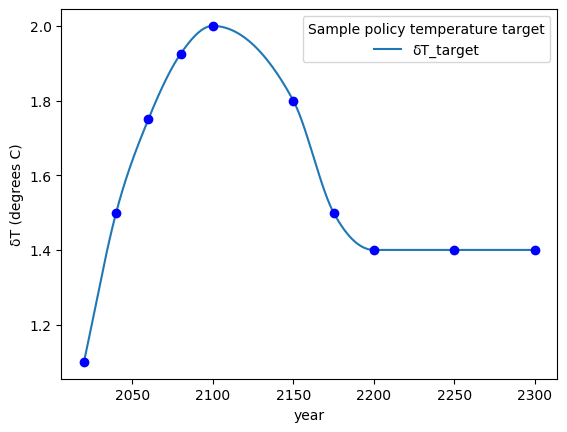

PyObject <matplotlib.legend.Legend object at 0x13f1b72b0>

In [89]:
# The following is a sample policy target.

target_years = [2020, 2040, 2060, 2080, 2100, 2150, 2175, 2200, 2250, 2300]
target_temps = [1.1,  1.5,  1.75, 1.925, 2.0, 1.8,  1.5, 1.4, 1.4, 1.4]
δT_target = interpolate_monotone_curve(target_years, target_temps)

ts = collect(2020:1:2300)
plot(ts, δT_target.(ts), label="δT_target")
plot(target_years, target_temps, "bo")
ylabel("δT (degrees C)")
xlabel("year")
legend(title="Sample policy temperature target")

# Actions

An _action_ is a four-tuple $u = (r, n, a, g)$ of 
nonnegative real values (measured in teradollars).
The action in year $t$ is denoted
$$
    u(t) = (r(t), n(t), a(t), g(t)) \ .
$$
These are the raw investment values for that year (that is,
without learning curve expansion factors).

In [90]:
Action = Vector{Float64}

# indices into an action (we avoid structs here for convenience)
# all units are teradollars; each component is for one-year investment
a_r = 1  # action's investment in emissions reduction
a_n = 2  # action's investment in negative emissions
a_a = 3  # action's investment in adaptation
a_g = 4  # action's investment in geoengineering

# The following doesn't work, since Julia then just interprets *any* Vector
# of Floats as an Action, and applies this routine.!
# function Base.show(io::IO, u::Action)
#     print(io, format("(r={:8.6f},n={:8.6f},a={:8.6f},g={:8.6f})",
#                      u[a_r], u[a_n], u[a_a], u[a_g]))
# end

4

# Damage at a state and cost of an action

The _damage_ at a state is proportional to the square of the increase in temperature. 
We estimate damage equal to 2% of GWP for a 3 degree (Kelvin) temperature increase.
(Note that we assume that the economy doesn't change here, so the same
approximation is used for all years, with 100 T\$ taken as GWP.)

In [91]:
const β = (0.02 * 100) / 3^2        # damage parameter (annual teradollars / C^2)
#     β = 0.222 teradollars / C^2   # agrees with Deutch value

# return damages for one year at given state, in teradollars
function damage_state(s::WorldState)
    
    # raw damages are based on temperature increase only
    raw_damages = β * s.δT^2
    
    # include consideration of geoengineering
    # infer deutch's corresponding alpha as
    alpha_G = clamp(s.G_net / 2.0, 0, 1)    # 2T$/yr max
    geo_raw_damages = raw_damages * (1 - alpha_G)^2
    
    # include consideration of adaptation
    alpha_A = clamp(s.A_net / 3.0, 0, 1)    # 3T$/yr max
    total_damages = geo_raw_damages * (1 - alpha_A)
    
    return total_damages
end

damage_state (generic function with 1 method)

The _cost_ of an action is just the sum of its four control variables $r$, $n$, $a$, and $g$, each of which is measured in teradollars.  This is a one-time investment
cost for building up capacity for a given approach.  There is no maintenance cost for a capacity, once built.  There probably should be.  The cost is measured in units of teradollars.

In [92]:
# return cost of an action in teradollars
function cost_action(u::Action)
    @assert all(u .>= 0)
    return sum(u)
end

cost_action (generic function with 1 method)

Now look at cost + damages for a sequence of actions and states.

In [93]:
function cost_plus_damages(state_sequence, action_sequence, discount_rate)
    n_year = length(state_sequence)
    discount_rates = [(1-discount_rate)^i for i in 1:n_years]
    action_cost_sequence = cost_action.(action_sequence) .* discount_rates
    damage_state_sequence = damage_state.(state_sequence) .* discount_rates
    total_cost_plus_damages = action_cost_sequence .+ damage_state_sequence
    # return damage_state_sequence, action_cost_sequence, total_cost_plus_damages
    # debug: println("CPD: damages=$(sum(damage_state_sequence)) actions=$(sum(action_cost_sequence)) total=$(sum(total_cost_plus_damages))")
    return sum(total_cost_plus_damages)
end

cost_plus_damages (generic function with 1 method)

# Economic model

The net new emissions in year $t$ are denoted $q(t)$, measured in ppm.
We assume that this is exogenous. 
We give here a sample $q(t)$, which has emissions
remaining flat until 2060, then decreasing thereafter, until it reaches 0.0 ppm.

In [94]:
q_years = [2020, 2060, 2250, 2300]
q_vals = [2.0,  2.0, 0.0, 0.0]
q = interpolate_monotone_curve(q_years, q_vals)

#141 (generic function with 1 method)

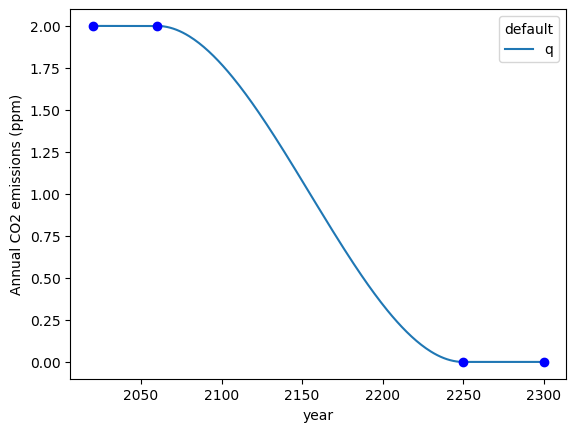

PyObject <matplotlib.legend.Legend object at 0x13caf7be0>

In [95]:
function plot_q(ts, qs, title)
    plot(ts, qs, label="q")
    plot(q_years, q_vals, "bo")
    ylabel("Annual CO2 emissions (ppm)")
    xlabel("year")
    legend(title=title)
end

plot_q(ts, q.(ts), "default")

We note that although Deutch used a 2ppm nominal increase in CO2
concentration per year, the actual figure is larger than that.
Some curve-fitting on the Keeling data show that the the concentration
in year $1990 + x$ is about
$$
    352.826 + 1.38762 x + 0.02017 x^2
$$
so the "correct" value for $q(t)$ in 2020 should be about 2.6:
$$
     1.38762 + 0.02017 \cdot 2 \cdot 30 = 2.59782\ .
$$

[//]: # (Comment: curve-fitting done for CLRS 4e, using kfit.jl code.)

# Climate model

Assume that time is discretized (annual).  

The climate model may contain stochastic elements. 

Let $N(0,1)$ denote a standard normal variate with mean $0$ and variance $1$.

The variables c_noise_scale and ECS_noise_scale define how "noisy" the
variables $c$ and $ECS$ are.  If they are $0$ then the climate model is deterministic.

The model assumes a fixed-rate (baseline) level of emissions $q=2$ in ppm at first, switching at 2060 to a decreasing emissions rate.
    
The climate model derives a next-state from the current state and the current action.

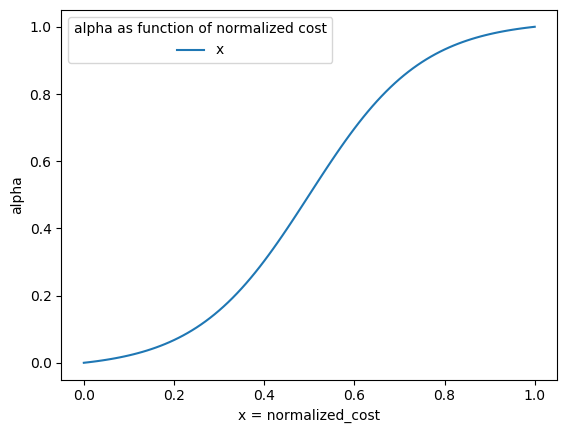

PyObject <matplotlib.legend.Legend object at 0x13f46e6a0>

In [96]:
## deterministic model for now; no jitter for c or for ECS
const c_noise_scale = 0.00       
const ECS_noise_scale = 0.00

Random.seed!(0)          # fix seed for reproducibility
                         # probably want separate seeds for c, ECS

const ES_decay = 0.9     # ES accumulates deviations with some discount
                         # applied to prior ES aggregate

const net_decay = 0.00    # "Depreciation rate" for investments once made NOTE 0.00 now!

# Cost scaling factors for each of the four strategies
const C_R = 1.0 # T$ / year 
const C_N = 2.0 # T$ / year
const C_A = 3.0 # T$ / year
const C_G = 5.0 # T$ / year 

## try several ways of defining f_inv (how alpha and cost of control are related)

const p = 1.0          # This is exponent for function f
                       # p < 1 --> good learning effects
                       # p = 1 --> neutral
                       # p > 1 --> diminishing returns
                       # although note that "learning effects" are also captured by 
                       # having a learning_exponent > 0.
function f(alpha)      # return cost for given alpha, normalized as fraction of scaling factor C
                       # maps interval [0,1] to interval [0,1]
    alpha = clamp(alpha, 0, 1)
    return alpha^p     
end

function f_inv(normalized_cost)  # return alpha for given normalized cost; inverse of f
                                 # maps interval [0,1] to interval [0,1]
    normalized_cost = clamp(normalized_cost, 0, 1)
    return normalized_cost ^ (1/p)
end

function f2_inv(normalized_cost) 
    # a different way of setting this up, so there is "logistic-like" behavior
    # maps [0,1] to [0,1]
    # here k is parameter, which should be in [0, 1/4]
    k = 0.25
    normalized_cost = clamp(normalized_cost, 0, 1)
    z = 2*normalized_cost - 1.0
    return (z+1)/2 + k * (z - z^3)
end

f3_xs = [0, 0.30, 0.5, 0.70, 1.0]
f3_ys = [0, 0.05, 0.5, 0.95, 1.0]
f3_inv = interpolate_monotone_curve(f3_xs, f3_ys)

function f4_inv(normalized_cost)
    # a different way of setting this up, so there is "logistic-like" behavior
    # maps [0,1] to [0,1]
    # here k is a nonnegative parameter; larger makes curver steeper
    # this curve has "learning curve" features at first, then "diminishing returns"
    normalized_cost = clamp(normalized_cost, 0, 1)
    k = 2
    z = k*(2*normalized_cost - 1.0)
    return 1/2 + 1/2 * tanh(z) / tanh(k)
end

xs = collect(0:0.01:1)
plot(xs, f4_inv.(xs), label="x")
ylabel("alpha")
xlabel("x = normalized_cost")
legend(title="alpha as function of normalized cost")

In [97]:
function next_state(s::WorldState, u::Action)
    @assert all(u .>= 0)

    next_t = s.t + 1

    alpha_R = f4_inv(s.R_net/C_R)
    alpha_N = f4_inv(s.N_net/C_N)
    
    # Note order of next two ops is reversed compared to JMD; shouldn't matter     
    next_c = s.c * (1 - alpha_N)
    next_c = next_c + q(s.t) * (1 - alpha_R)

    next_c = next_c + c_noise_scale * randn()  
    next_c = max(280, next_c)         # note ??  Don't let c drop below 280 ppm
    
    next_δT = δT_1  +  s.ECS * lg(s.c/c_1)  # recall lg is log_2
    
    next_ECS = s.ECS + ECS_noise_scale * randn() 
    next_ECS = max(1.0, next_ECS)     # note ?? Don't let ECS drop below 1.0

    # add to cumulative investments
    
    r_eff = u[a_r] 
    r_eff *= (s.R_cum/II) ^ learning_exponent
    next_R_cum = s.R_cum + r_eff
    next_R_net = s.R_net*net_decay + r_eff
    
    n_eff = u[a_n] 
    n_eff *= (s.N_cum/II) ^ learning_exponent
    next_N_cum = s.N_cum + n_eff
    next_N_net = s.N_net*net_decay + n_eff
    
    a_eff = u[a_a] 
    a_eff *= (s.A_cum/II) ^ learning_exponent
    next_A_cum = s.A_cum + a_eff
    next_A_net = s.A_net*net_decay + a_eff
    
    g_eff = u[a_g] 
    g_eff *= (s.G_cum/II) ^ learning_exponent
    next_G_cum = s.G_cum + g_eff
    next_G_net = s.G_net*net_decay + g_eff
    
    # determine error signal for this state
    next_error = δT_target(next_t) - next_δT
    if sign(next_error) != sign(s.ES)
        next_ES = next_error
    else
        next_ES = next_error + s.ES * ES_decay
    end
    
    next_GWP = s.GWP

    next_s = WorldState(next_t, next_c, next_δT, next_ECS,
                        next_R_cum, next_R_net,
                        next_N_cum, next_N_net,
                        next_A_cum, next_A_net,
                        next_G_cum, next_G_net,
                        next_ES,
                        next_GWP)
    return next_s
end

test_action = Action([0.01, 0.005, 0.02, 0.003]) 
s2 = next_state(start_state, test_action)
s3 = next_state(s2, test_action)
println(s2)
println(s3)

(t=2021,c=417.0,δT=1.10,ECS=3.0,R_cum=0.020,R_net=0.010,N_cum=0.015,N_net=0.005,A_cum=0.030,A_net=0.020,G_cum=0.013,G_net=0.003,ES=0.02,GWP=100.00)
(t=2022,c=418.8,δT=1.12,ECS=3.0,R_cum=0.030,R_net=0.010,N_cum=0.020,N_net=0.005,A_cum=0.050,A_net=0.020,G_cum=0.016,G_net=0.003,ES=0.04,GWP=100.00)


## Policies

A policy gives a two-segment piece-wise linear function for each of
the four strategies, saying how much to invest annual in that strategy
as a function of the error signal ES (which is excess of the current temperature increase
over the current target temperature increase).

Elements of policy are as follows:
There are two floats per strategy, so a policy is a vector of length eight.
The two values for a given strategy define a piece-wise linear
function maping error signals to investment levels, as follows:
  - the first number (the "threshold") gives the error signal below
    which the strategy is not used.  (This value may be positive or negative.)
  - the second number gives the investments (in T$ per degree C) to be made
    in that strategy for each degree C that the error signal exceeds the
    the threshold for that strategy.
We call these the "threshold" and the "slope" for that policy for that strategy.

In [190]:
# Declare policy as a Float64 Vector, since that is what will
# be needed for optimization routines (rather than a struct, say).

Policy = Vector{Float64}

# indices into policy
p_r_threshold = 1
p_r_slope = 2
p_n_threshold = 3
p_n_slope = 4
p_a_threshold = 5
p_a_slope = 6
p_g_threshold = 7
p_g_slope = 8

test_policy = Policy([0.00,   0.80,
                      0.04,   0.64,
                      0.08,   0.48,
                      0.12,   0.32]
                     );

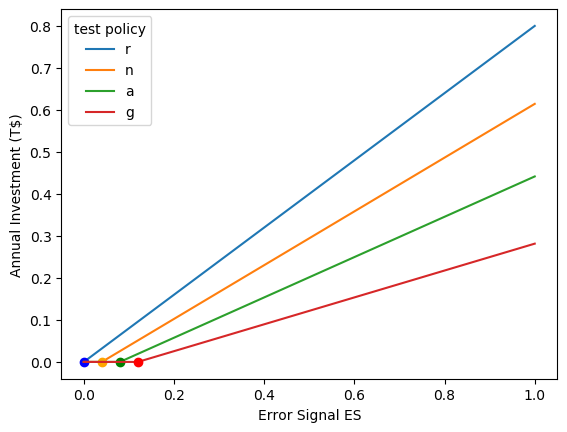

PyObject <matplotlib.legend.Legend object at 0x14023e208>

In [191]:
function plot_policy(p::Policy, title)
    ESs = collect(0.0:0.01:1.0)
    rs = max.(0, (ESs.-p[p_r_threshold])*p[p_r_slope])
    plot(ESs, rs, label="r")
    plot(p[p_r_threshold], 0, "bo")
    ns = max.(0, (ESs.-p[p_n_threshold])*p[p_n_slope])
    plot(ESs, ns, label="n")
    plot(p[p_n_threshold], 0, color="orange", "o")
    as = max.(0, (ESs.-p[p_a_threshold])*p[p_a_slope])
    plot(ESs, as, label="a")
    plot(p[p_a_threshold], 0, "go")
    gs = max.(0, (ESs.-p[p_g_threshold])*p[p_g_slope])
    plot(ESs, gs, label="g")
    plot(p[p_g_threshold], 0, "ro")
    ylabel("Annual Investment (T\$)")
    xlabel("Error Signal ES")
    legend(title=title)
end

plot_policy(test_policy, "test policy")

In [192]:
function apply_policy(p::Policy, s::WorldState)
    # return action for given WorldState according to given Policy
    # (positive) error signal in degrees C (>0 means it's too hot!)
    ES = max(0, s.δT - δT_target(s.t))
    thresholds = p[1:2:7]
    slopes = p[2:2:8]
    u = Action(max.(0, (ES .- thresholds) .* slopes))
    return u
end

apply_policy (generic function with 1 method)

In [193]:
function run_policy(p::Policy, start_state::WorldState, n_steps)
    state = start_state
    state_sequence = []
    action_sequence = []
    for t in 1:n_steps
        action = apply_policy(p, state)
        push!(state_sequence, state)
        push!(action_sequence, action)
        state = next_state(state, action)
    end
    return state_sequence, action_sequence
end

run_policy (generic function with 1 method)

In [194]:
n_years = 281    # was 81 to go up to year 2100
ts = collect(t_1:t_1+n_years-1)
state_sequence, action_sequence = run_policy(test_policy, start_state, n_years)
rs = collect(u[a_r] for u in action_sequence)
ns = collect(u[a_n] for u in action_sequence)
as = collect(u[a_a] for u in action_sequence)
gs = collect(u[a_g] for u in action_sequence)
cs = collect(s.c for s in state_sequence)
δTs = collect(s.δT for s in state_sequence)
ECSs = collect(s.ECS for s in state_sequence)
Rcums = collect(s.R_cum for s in state_sequence)
Rnets = collect(s.R_net for s in state_sequence)
Ncums = collect(s.N_cum for s in state_sequence)
Nnets = collect(s.N_net for s in state_sequence)
Acums = collect(s.A_cum for s in state_sequence)
Anets = collect(s.A_net for s in state_sequence)
Gcums = collect(s.G_cum for s in state_sequence)
Gnets = collect(s.G_net for s in state_sequence);

In [195]:
const discount_rate = 0.00 # use 0 or 0.014 or 0.025

function cost_policy(policy, 
                     n_years = n_years, 
                     discount_rate = discount_rate)
    state_sequence, action_sequence = run_policy(policy, start_state, n_years)
    return cost_plus_damages(state_sequence, action_sequence, discount_rate)[end]
end

println(cost_policy(test_policy, n_years, discount_rate))

201.23896455460326


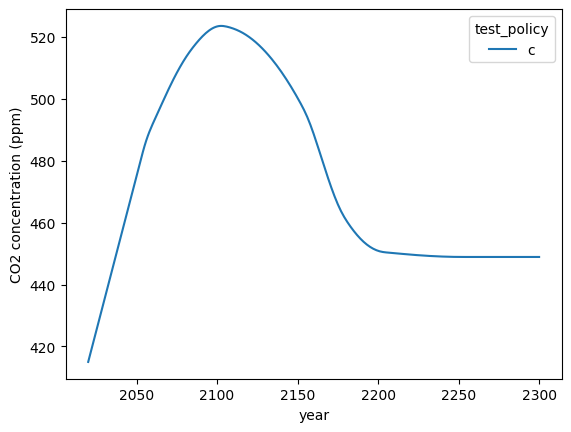

In [196]:
function plot_c(ts, cs, title)
    plot(ts, cs, label="c")
    ylabel("CO2 concentration (ppm)")
    xlabel("year")
    legend(title=title)
end

plot_c(ts, cs, "test_policy");

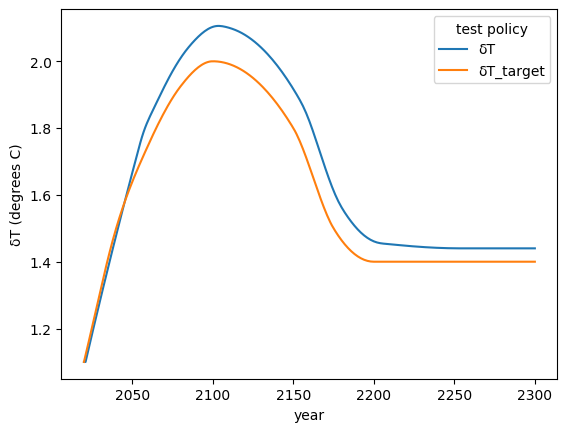

In [197]:
function plot_δTs(ts, δTs, title)
    plot(ts, δTs, label="δT")
    δT_targets = δT_target.(ts)
    plot(ts, δT_targets, label="δT_target")
    ylabel("δT (degrees C)")
    xlabel("year")
    legend(title=title)
end

plot_δTs(ts, δTs, "test policy");

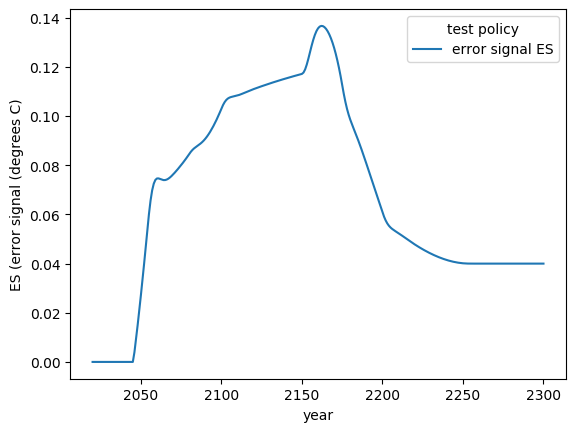

In [198]:
function plot_ESs(ts, δTs, title)
    ESs = max.(0, δTs .- δT_target.(ts))
    plot(ts, ESs, label="error signal ES")
    ylabel("ES (error signal (degrees C)")
    xlabel("year")
    legend(title=title)
end

plot_ESs(ts, δTs, "test policy");

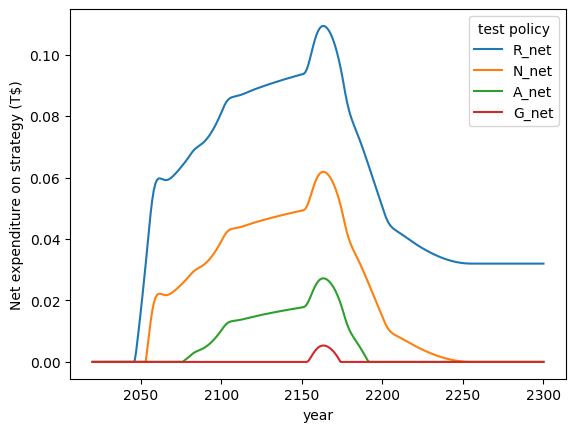

In [199]:
function plot_nets(ts, Rnets, Nnets, Anets, Gnets, title)
    plot(ts, Rnets, label="R_net")
    plot(ts, Nnets, label="N_net")
    plot(ts, Anets, label="A_net")
    plot(ts, Gnets, label="G_net")
    ylabel("Net expenditure on strategy (T\$)")
    xlabel("year")
    legend(title=title)
end

plot_nets(ts, Rnets, Nnets, Anets, Gnets, "test policy");

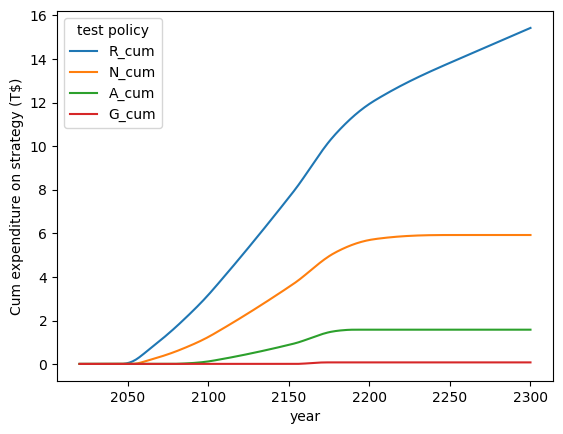

In [200]:
function plot_cums(ts, Rcums, Ncums, Acums, Gcums, title)
    plot(ts, Rcums, label="R_cum")
    plot(ts, Ncums, label="N_cum")
    plot(ts, Acums, label="A_cum")
    plot(ts, Gcums, label="G_cum")
    ylabel("Cum expenditure on strategy (T\$)")
    xlabel("year")
    legend(title=title)
end

plot_cums(ts, Rcums, Ncums, Acums, Gcums, "test policy");

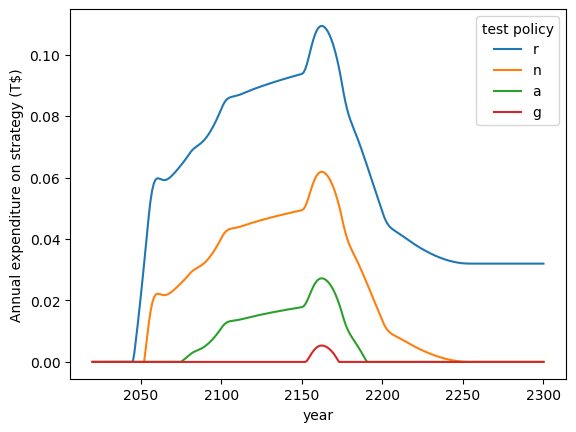

In [201]:
function plot_controls(ts, rs, ns, as, gs, title)
    plot(ts, rs, label="r")
    plot(ts, ns, label="n")
    plot(ts, as, label="a")
    plot(ts, gs, label="g")
    ylabel("Annual expenditure on strategy (T\$)")
    xlabel("year")
    legend(title=title)
end

plot_controls(ts, rs, ns, as, gs, "test policy");

# Find optimal policy

Policies are nonnegative two-part piecewise-linear continuous functions of the temperature increase:
zero for temperature increase less than some threshold, then rising linearly with some given slope
after that.

In [235]:
SearchRange = [(0.0, 1.0), # for r: for p[p_r_threshold] (units degrees C)
               (0.0, 0.8), #        for p[p_r_slope] (units T$ per degree C)
               (0.0, 1.0), # for n  
               (0.0, 0.64), 
               (0.0, 1.0), # for a
               (0.0, 0.1),  
               (0.0, 1.0), # for g
               (0.0, 0.36) 
              ]

res = bboptimize(cost_policy; SearchRange = SearchRange)

optimal_policy = best_candidate(res)

println("optimal_policy = $optimal_policy")
println("cost+damages of best_policy is $(cost_policy(optimal_policy))")

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 155 evals, 97 steps, improv/step: 0.536 (last = 0.5361), fitness=181.915992441
1.00 secs, 306 evals, 220 steps, improv/step: 0.482 (last = 0.4390), fitness=178.257280137
1.51 secs, 459 evals, 366 steps, improv/step: 0.484 (last = 0.4863), fitness=178.257280137
2.01 secs, 613 evals, 520 steps, improv/step: 0.498 (last = 0.5325), fitness=177.921460937
2.52 secs, 769 evals, 676 steps, improv/step: 0.515 (last = 0.5705), fitness=177.671188115
3.02 secs, 925 evals, 832 steps, improv/step: 0.528 (last = 0.5833), fitness=177.645432357
3.52 secs, 1076 evals, 983 steps, improv/step: 0.539 (last = 0.6026), fitness=177.645432357
4.02 secs, 1223 evals, 1130 steps, improv/step: 0.546 (last = 0.5918), fitness=177.628467476
4.52 secs, 1372 evals, 1279 steps, improv/step: 0.554 (last = 0.6174)

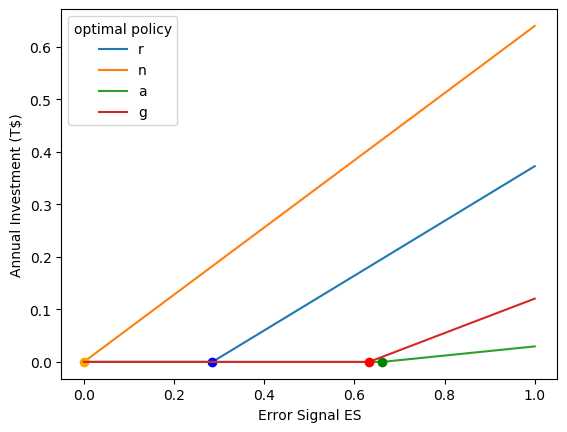

optimal policy[0.285052, 0.521495, 3.43174e-21, 0.64, 0.661203, 0.0872182, 0.632333, 0.327877]


In [236]:
println("optimal policy", optimal_policy)
plot_policy(optimal_policy, "optimal policy");

In [237]:
state_sequence, action_sequence = run_policy(optimal_policy, start_state, n_years)
qs = collect(q(t) for t in ts)
rs = collect(u[a_r] for u in action_sequence)
ns = collect(u[a_n] for u in action_sequence)
as = collect(u[a_a] for u in action_sequence)
gs = collect(u[a_g] for u in action_sequence)
cs = collect(state.c for state in state_sequence)
δTs = collect(state.δT for state in state_sequence)
ECSs = collect(state.ECS for state in state_sequence)
Rcums = collect(s.R_cum for s in state_sequence)
Rnets = collect(s.R_net for s in state_sequence)
Ncums = collect(s.N_cum for s in state_sequence)
Nnets = collect(s.N_net for s in state_sequence)
Acums = collect(s.A_cum for s in state_sequence)
Anets = collect(s.A_net for s in state_sequence)
Gcums = collect(s.G_cum for s in state_sequence)
Gnets = collect(s.G_net for s in state_sequence);

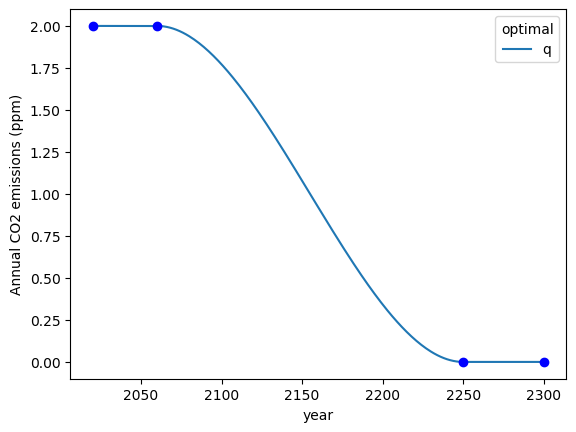

In [238]:
plot_q(ts, qs, "optimal");        # this is exogenous

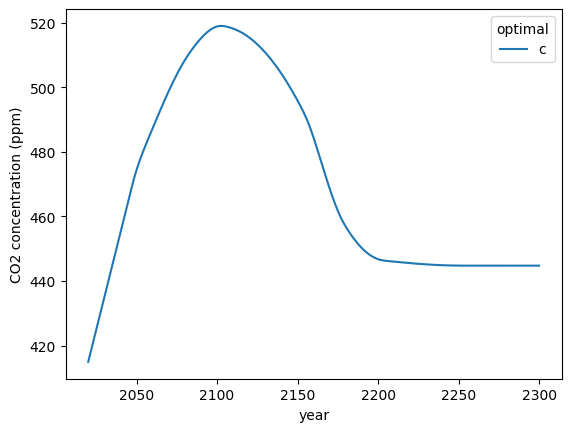

In [239]:
plot_c(ts, cs, "optimal");

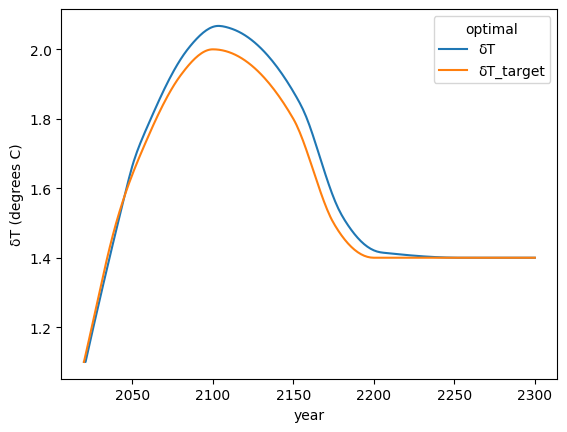

In [240]:
plot_δTs(ts, δTs, "optimal");

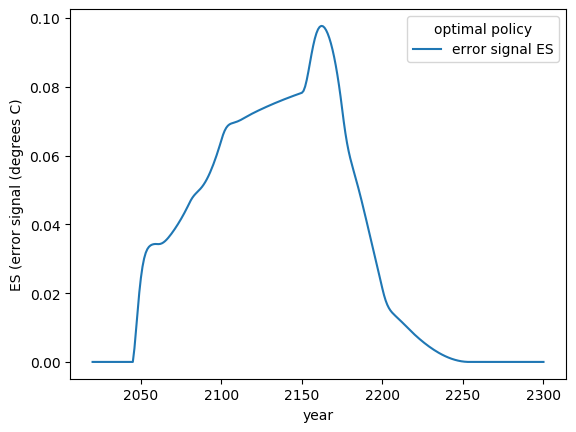

In [241]:
plot_ESs(ts, δTs, "optimal policy");

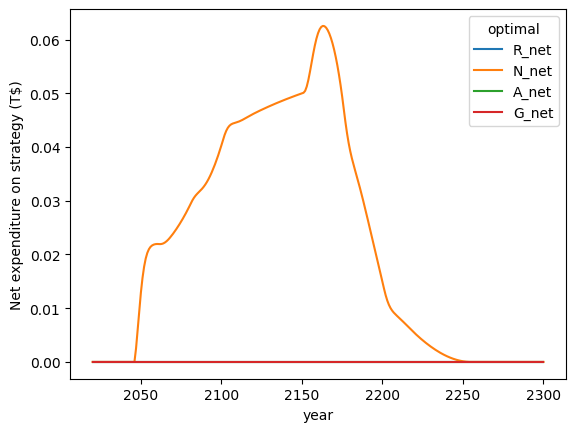

In [242]:
plot_nets(ts, Rnets, Nnets, Anets, Gnets, "optimal");

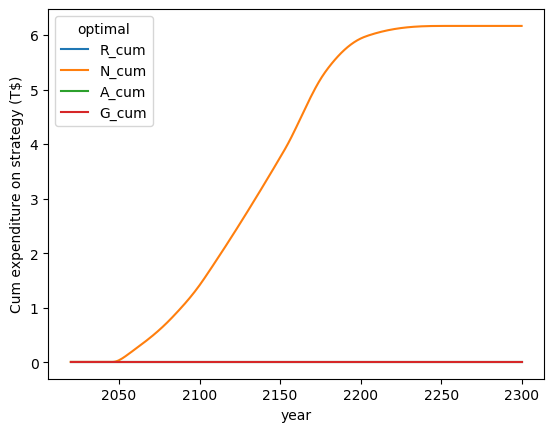

In [243]:
plot_cums(ts, Rcums, Ncums, Acums, Gcums, "optimal");

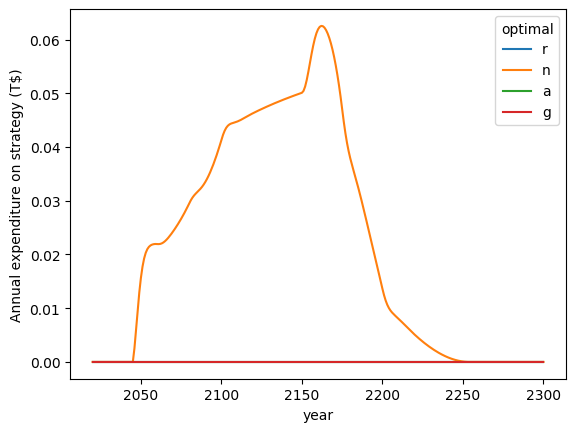

In [244]:
plot_controls(ts, rs, ns, as, gs, "optimal");

In [245]:
println("Last action = ", apply_policy(optimal_policy, state_sequence[end]))

Last action = [0.0, 0.0, 0.0, 0.0]
